In [ ]:
import kagglehub
from google.colab import drive
# Download latest version
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")

print("Path to dataset files:", path)

caption_path = '/root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json'


drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/phase3'

100%|██████████| 13.7G/13.7G [02:08<00:00, 115MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1
Mounted at /content/drive


In [ ]:
import json
import kagglehub
from google.colab import drive
import os
import zipfile
import random
import shutil

# Path to the captions_train2014.json file
input_file_path = '/root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json'
output_file_path = f'{base_dir}/coco.txt'

# Variable for the word count threshold
n = 20  # Adjust this value as needed

# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

# Prepare the result
results = []

cnt = 0
# Process the annotations
for annotation in data['annotations']:
    caption = annotation['caption']
    word_count = len(caption.split())
    if word_count < n:
        if cnt == 40000:
            break
        cnt += 1
        if cnt % 1000 == 0:
            print(cnt)
        # Find the corresponding image
        image_id = annotation['image_id']
        image_info = next(
            img for img in data['images'] if img['id'] == image_id)
        image_file_name = image_info['file_name']
        # Add to results
        results.append(f"{image_file_name},{caption}")

# Save the results to a text file
with open(output_file_path, 'w') as output_file:
    for line in results:
        output_file.write(line + '\n')

print(f"Results saved to {output_file_path}")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
Results saved to /content/drive/MyDrive/phase3/coco.txt


In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("hsankesara/flickr-image-dataset")

# print("Path to dataset files:", path)
# image_path = "/root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/flickr30k_images/flickr30k_images/"

100%|██████████| 8.16G/8.16G [04:20<00:00, 33.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1


In [ ]:
!ls /root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/flickr30k_images/results.csv

/root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/flickr30k_images/results.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = '/content/drive/MyDrive/phase3'

import sys
sys.path.append('/content/drive/MyDrive/phase3')

Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
import time
import numpy as np

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from ph3 import *
import os
import torch.optim as optim
import torch
import pickle


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
if torch.cuda.is_available:
  print('Good to go!')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


In [ ]:
# Configuration
image_size = (299, 299)
flicker = 'coco'
# data_path = image_path
# captions_path = '/root/.cache/kagglehub/datasets/hsankesara/flickr-image-dataset/versions/1/flickr30k_images/results.csv'
data_dict_path = f"{base_dir}/flicker30k.pt"
data_path = '/root/.cache/kagglehub/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014'
captions_path = f'{base_dir}/coco.txt'
data_dict = load_data(data_dict_path, captions_path, data_path,
                      vocab_path=f"{base_dir}/captions.txt",
                      flicker=flicker, test_size=0.05, min_freq=1)

The file '/content/drive/MyDrive/phase3/flicker30k.pt' does not exist. Creating a new dataset...
30192


In [ ]:
num_train = len(data_dict['train_images'])
num_val = len(data_dict['val_images'])
print(f'num_train: {num_train}')
print(f'num_val: {num_val}')

num_train: 30192
num_val: 1590


### function for data augmentation

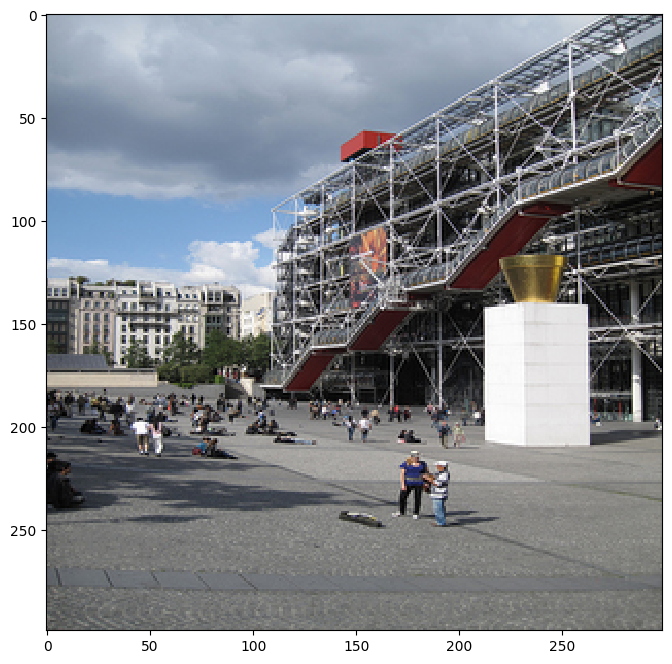

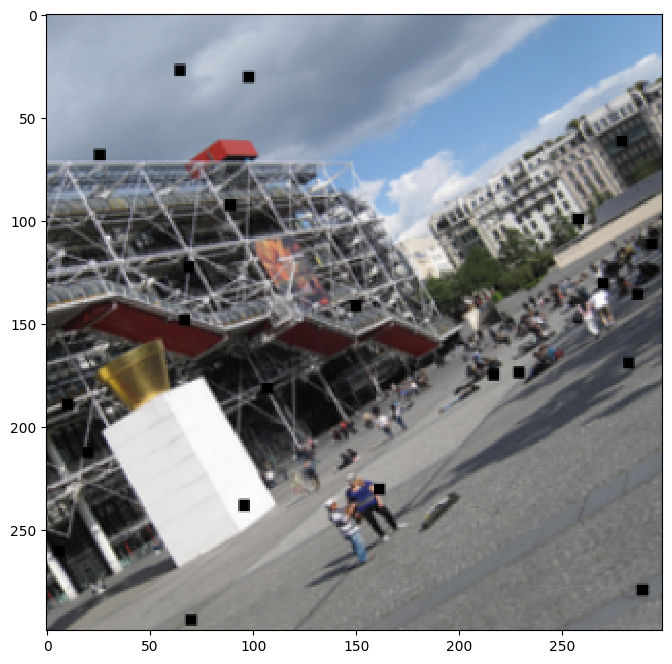

In [ ]:
ag_img = process_images(read_images(data_dict['train_images'][2057], image_size), image_size=image_size, augment=True, num_augmented=1)
for i in range(ag_img.shape[0]):
    img = ag_img[i].permute(1, 2, 0).to(torch.int32)
    plt.imshow(img)
    plt.show()

In [ ]:
data_dict['train_captions'].shape

torch.Size([30192, 5, 24])

In [ ]:
len(data_dict["vocab"]["idx_to_token"])

8782

We have 6,472 lists of captions.

- Each list contains 5 captions.  
- Each caption consists of 40 tokens (with padding).  
- Each token is represented as a vector of size 8,908 (one-hot encoding).  


In [ ]:
PAD_index = 0

`start = 1`,
`end = 2`,
`pad = 0`

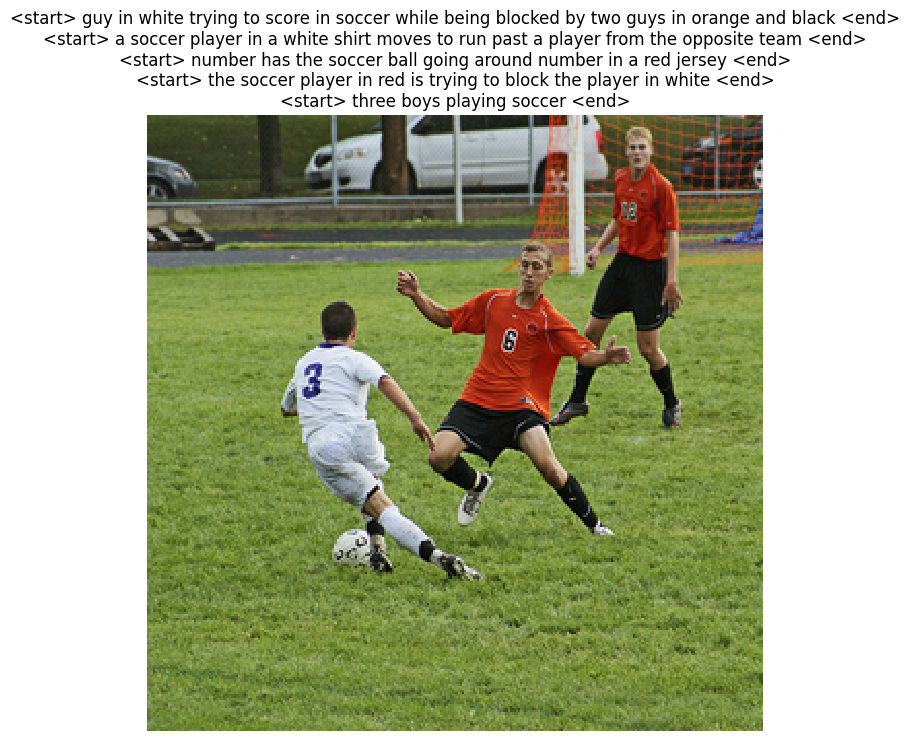

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images and captions
image_num = 155

sample_images = read_images(data_dict['train_images'][image_num], image_size)
sample_captions = data_dict['train_captions'][image_num]
plt.imshow(process_images(sample_images, image_size=image_size).permute(1, 2, 0).to(torch.int32))
plt.axis('off')
caption_str = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
caption_str = "\n".join(caption_str)
plt.title(caption_str)
plt.show()

### RNN

In [ ]:
# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          token_to_idx = data_dict['vocab']['idx_to_token'],
          input_dim=1280,
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=PAD_index,
          **to_float_cuda)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 103MB/s]


In [ ]:
# Model and file paths
name = 'flicker30k'
version = 1
checkpoint_path = f'{base_dir}/checkpoint/{name}_{version}_checkpoint.pth'
model_path = f'{base_dir}/models/{name}_{version}_checkpoint.pth'
history_path = f'{base_dir}/history/{name}_{version}.pth'

lr = 2e-3
epochs = 200
lr_decay = 0.97
batch_size= 380
weight_decay = 5e-4
interval = 20

if os.path.exists(checkpoint_path):
    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model = rnn_model.to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))
    scheduler = CosineAnnealingLR(optimizer, T_max=50)
    # scheduler = None

    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    train_loss_history = checkpoint['train_loss_history']
    val_loss_history = checkpoint['val_loss_history']
    best_val_loss = checkpoint['best_val_loss']
    print(f"Training will resume from epoch {start_epoch}.\n")

else:
    # Start new training
    print(f"Training new model: {name}\n")

    # Initialize model and optimizer
    model = rnn_model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    # optimizer = optim.SGD(model.fc.parameters(), min_lr)

    # Define scheduler
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: lr_decay ** (epoch // interval))
    scheduler = CosineAnnealingLR(optimizer, T_max=50)
    # scheduler = None

    # Initialize metrics and state
    start_epoch = 0
    best_val_acc = 0.0

#################################################################################################
#                                               TEST                                            #
#################################################################################################
# image_num = 13

# sample_images = read_images(data_dict['train_images'][image_num], image_size)
# sample_captions = data_dict['train_captions'][image_num]
# img = process_images(sample_images, image_size=image_size).unsqueeze(0).to(torch.int32)
# captions = sample_captions.unsqueeze(0).to(device)
# loss = model(img, captions, 0)


# plt.imshow(process_images(sample_images, image_size=image_size).permute(1, 2, 0).to(torch.int32))
# plt.axis('off')
# caption_str = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
# caption_str = "\n".join(caption_str)
# plt.title(caption_str)
# plt.show()
#################################################################################################
#                                               END                                            #
#################################################################################################


#Train model
train_loss_history, val_loss_history = train_captioning_model(
    rnn_model, optimizer, data_dict, device='cuda', dtype=torch.float32, lr=lr,
    epochs=epochs, batch_size=batch_size, scheduler=scheduler, weight_decay=weight_decay,
    image_size=image_size, verbose=True, checkpoint_path=checkpoint_path
)

# Save final model and history after training completes
torch.save(model.state_dict(), model_path)
print(f"Final model saved at: {model_path}")

with open(history_path, 'wb') as f:
    pickle.dump((train_loss_history, val_loss_history), f)
print(f"Training history saved at: {history_path}")

Resuming training from checkpoint: /content/drive/MyDrive/phase3/checkpoint/flicker30k_1_checkpoint.pth


<ipython-input-15-a0937ce0beea>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Training will resume from epoch 117.

Resuming training from checkpoint...


/content/drive/MyDrive/phase3/ph3.py:1313: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resumed training from epoch 117
Epoch 118/200
  Batch 1/79, lr = 0.00090000, Loss = 35.9734
  Batch 21/79, lr = 0.00090000, Loss = 69.7737
  Batch 41/79, lr = 0.00090000, Loss = 34.0466
  Batch 61/79, lr = 0.00090000, Loss = 62.1767
  Training Loss: 43.0226, BLEU Reward: 0.08404
  Validation Loss: 34.8524
Epoch 119/200
  Batch 1/79, lr = 0.00088152, Loss = 60.1561
  Batch 21/79, lr = 0.00088152, Loss = 59.0750
  Batch 41/79, lr = 0.00088152, Loss = 38.4586
  Batch 61/79, lr = 0.00088152, Loss = 39.7478
  Training Loss: 39.6221, BLEU Reward: 0.11755
  Validation Loss: 34.0912
Epoch 120/200
  Batch 1/79, lr = 0.00086312, Loss = 25.8502
  Batch 21/79, lr = 0.00086312, Loss = 26.3460
  Batch 41/79, lr = 0.00086312, Loss = 30.9548
  Batch 61/79, lr = 0.00086312, Loss = 32.8024
  Training Loss: 38.8425, BLEU Reward: 0.12432
  Validation Loss: 32.5098
Epoch 121/200
  Batch 1/79, lr = 0.00084481, Loss = 30.5242
  Batch 21/79, lr = 0.00084481, Loss = 39.1897
  Batch 41/79, lr = 0.00084481, Loss

In [ ]:
plt.plot(train_loss_history)

In [ ]:
plt.plot(val_loss_history)

In [ ]:
batch_size = 5
from torchvision.utils import make_grid
from torchvision import transforms

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = process_images_batch([read_images(data_dict[split+'_images'][i], image_size) for i in sample_idx]
                            , image_size=image_size, augment=False)
  sample_captions = data_dict[split+'_captions'][sample_idx][:,random.randint(0, 4),:]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  model.eval()
  generated_captions, attn_weights_all = model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0)/255)
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

    tokens = generated_captions[i].split(' ')

    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))

    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)